In [1]:
# Import necessary libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.datasets import fetch_openml # MNIST data
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
# %matplotlib inline

## [2] 1D Ising - Regression
Different performances of linear regression on predicting the energy in
the 1D Ising model depending on choice of regularisation. We analyse
this performance a bit further.  
* Instead of the built-in scoring function, we plot the error $E_{out}$ for specific choice of parameters
* How does the performance change when changing the number of samples?  

### Solution

Forr a chain of $L$ spins:
$
H = - J s_i s_{i+1}
$
with periodocity!

Help for understanding ``einsum``
$$ np.einsum(...i,ij,...j->..., A, B,C) = (\sum_{i,j} A_{a_1,...,a_n,i}B_{ij}C_{a_1,...,a_n, j})_{a_1,...,a_n}$$
i.e. explicit index summation and implicit element-wise product (for implicit axis!)

An easier explicit example: $$ (A@ B).T = np.einsum("ij, jk -> ki", A, B)$$
And for the following example: $$\begin{pmatrix} H_1 \\ ... \\ H_{n\_ states} \end{pmatrix} = \begin{pmatrix} chain_1^T J chain_1  \\ ... \\ chain_{n\_ states}^T J chain_{n\_ states} \end{pmatrix}  =  np.einsum('...i,ij,...j->...',states,J,states) $$
where $chain_i = \begin{pmatrix} s_1^i \\ ... \\ s_L^i \end{pmatrix}$

Note that this doesn't necessarily perform a sum over indices... it can handle eg transposing or element-wise multi.

In [ ]:
# Define tensors A, B, and C
A = np.random.rand(2, 3, 4)  # Shape (2, 3, 4)
B = np.random.rand(4, 5)     # Shape (4, 5)
C = np.random.rand(2, 3, 5)  # Shape (2, 3, 5)

# Perform the einsum operation
result = np.einsum('...i,ij,...j->...', A, B, C)

#Can you guess the shape?
print(result.shape)

Look at the MSE instead of $R^2$

In [ ]:
# Wrap code in to a function 'ising()' because we want to adjust the number of samples later. 
def ising(n_samples, L):
    # create 10000 random Ising states
    n_states= 10000
    states = np.random.choice([-1, 1], size=(n_states, L))

    def ising_energies(states,L):
        """
        This function calculates the energies of the states in the nn Ising Hamiltonian
        """
        J = np.zeros((L,L),)
        for i in range(L):
            J[i,(i+1)%L] -= 1.0 # effectively J = 1 and seems to be the same for all pairs.
        # compute energies
        E = np.einsum('...i,ij,...j->...',states,J,states) # so this has dimension (n_states,1)

        return E
    
    # calculate Ising energies
    energies=ising_energies(states,L) # so this has dimension (n_states,1)

    # reshape Ising states into RL samples: S_iS_j --> X_p
    states = np.einsum('...i,...j->...ij', states, states) # For each sample, we want the matrix (s_i s_j)_{i,j}, so dimensions = (n_samples, L, L)
    shape = states.shape

    states = states.reshape((shape[0],shape[1]*shape[2])) ## flatten each (s_i s_j)_{i,j}, so dimensions = (n_samples, L*L)
    # build final data set
    Data = [states,energies]

    # define train and test data sets
    X_train = Data[0][:n_samples]
    Y_train = Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
    X_test = Data[0][n_samples:3*n_samples//2]
    Y_test = Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

    # set up Lasso and Ridge Regression models
    leastsq=linear_model.LinearRegression()
    ridge=linear_model.Ridge()
    lasso = linear_model.Lasso()

    # define error lists
    test_errors_leastsq = []

    test_errors_ridge = []

    test_errors_lasso = []

    ## hyperparameters scan/optim by hand
    # set regularisations strength values
    lmbdas = np.logspace(-4, 5, 10)

    #Initialize coeffficients for ridge regression and Lasso
    coefs_leastsq = []
    coefs_ridge = []
    coefs_lasso = []

    for lmbda in lmbdas:

        ### ordinary least squares
        leastsq.fit(X_train, Y_train) # fit model 
        coefs_leastsq.append(leastsq.coef_) # store weights
        # use the coefficient of determination R^2 as the performance of prediction.
        #train_errors_leastsq.append(leastsq.score(X_train, Y_train))
        #test_errors_leastsq.append(leastsq.score(X_test,Y_test))

        # use E_out as a measure of performance
        test_errors_leastsq.append(metrics.mean_squared_error(leastsq.predict(X_test),Y_test))

        ### apply Ridge regression
        ridge.set_params(alpha = lmbda) # set regularisation parameter
        ridge.fit(X_train, Y_train) # fit model 
        coefs_ridge.append(ridge.coef_) # store weights
        # use the coefficient of determination R^2 as the performance of prediction.
        #train_errors_ridge.append(ridge.score(X_train, Y_train))
        #test_errors_ridge.append(ridge.score(X_test,Y_test))

        # use E_out as a measure of performance
        test_errors_ridge.append(metrics.mean_squared_error(ridge.predict(X_test),Y_test))

        ### apply Ridge regression
        lasso.set_params(alpha = lmbda) # set regularisation parameter
        lasso.fit(X_train, Y_train) # fit model
        coefs_lasso.append(lasso.coef_) # store weights
        # use the coefficient of determination R^2 as the performance of prediction.
        #train_errors_lasso.append(lasso.score(X_train, Y_train))
        #test_errors_lasso.append(lasso.score(X_test,Y_test))

        # use E_out as a measure of performance
        test_errors_lasso.append(metrics.mean_squared_error(lasso.predict(X_test),Y_test))
    return [test_errors_leastsq, test_errors_ridge, test_errors_lasso]


# Plotting routine for visualizing Eout vs. regularization strength
def plot_ising_error(plot_title, errors):
    plt.figure()
    lmbdas = np.logspace(-4, 5, 10)
    plt.scatter(np.log(lmbdas), errors[0], label = 'leastsq', marker = 'x')
    plt.scatter(np.log(lmbdas), errors[1], label = 'ridge')
    plt.scatter(np.log(lmbdas), errors[2], label = 'lasso', marker = '+')
    plt.legend()
    plt.ylabel('$E_{out}$')
    plt.title(plot_title)
    plt.xlabel('log($\lambda$) [regularization strength]')

c:\Users\yoann\OneDrive - University of Cambridge\PhD\Teaching\Mphil\ML M1\my_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.484e-01, tolerance: 4.163e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\yoann\OneDrive - University of Cambridge\PhD\Teaching\Mphil\ML M1\my_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.219e+00, tolerance: 4.163e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\yoann\OneDrive - University of Cambridge\PhD\Teaching\Mphil\ML M1\my_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did

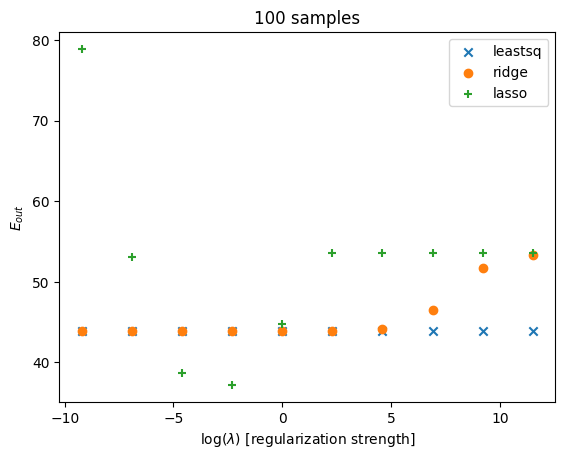

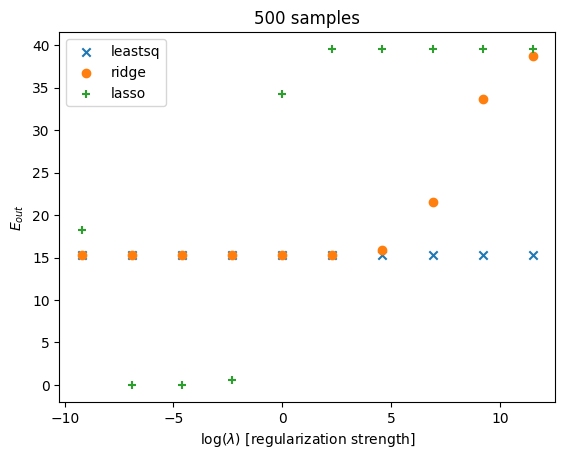

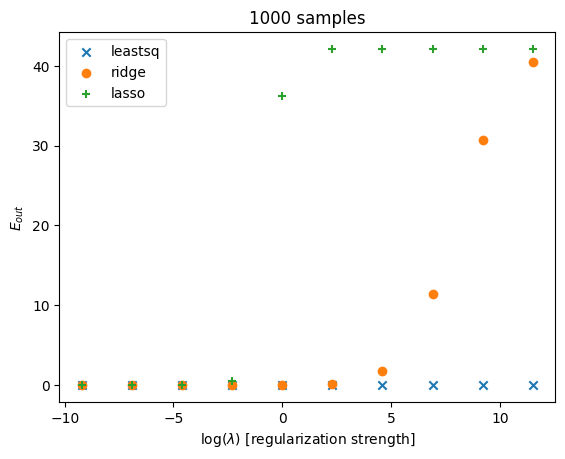

In [3]:
plot_ising_error('100 samples', ising(100, 40))
plot_ising_error('500 samples', ising(500, 40))
plot_ising_error('1000 samples', ising(1000, 40))

The best possible $E_{out}$ decreases drastically as a function of the number of samples for all methods. For ridge regression, the regularization strength should be sufficiently small (depending on the number of samples). For LASSO, there is an optimal value for the regularization strength, as the error does not behave monotonically. For the 100 or 500 samples it performs best among all methods, given that $\lambda\sim 10^{-5}$, probably because handling outliers better for small datasets (outliers are more insignificant with more data). 

COmparison with $R^2$: pretty similar! https://gitlab.developers.cam.ac.uk/phy/data-intensive-science-mphil/lecture-materials/m1_ml_for_dis/-/blob/main/notebooks/Ising1d_linearregression%202.ipynb?ref_type=heads

- With a small dataset, the model has fewer data points to generalize from, so it’s more prone to overfitting—fitting noise or specific idiosyncrasies of the limited sample rather than capturing the underlying relationship. Regularisations help with that. And Lasso helps particularly well with outliers.
- Regularisation is also beneficial for high-dimensional data (where the number of features is large relative to the number of samples, which is the case here), as regularization constrains the model complexity.
